In [1]:
from netCDF4 import Dataset

import numpy as np

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import current_weather, sky_cover, StationPlot, simple_layout, wx_code_to_numeric
from metpy.io import metar

import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from functions_final.py import upperairproj

In [2]:
nc = Dataset('20211211_0500')

In [3]:
#read in variables needed for plotting surface station plots
station_name = nc.variables['stationName'][:]
latitude = nc.variables['latitude'][:]
longitude = nc.variables['longitude'][:]
temp = (nc.variables['temperature'][:]-273.15)*(9/5)+32.0
dwpt = (nc.variables['dewpoint'][:]-273.15)*(9/5)+32.0
wspd = nc.variables['windSpeed'][:]
wdir = nc.variables['windDir'][:]
gust = nc.variables['windGust'][:]
weather = nc.variables['presWeather'][:]
visibility = nc.variables['visibility'][:]
pslp = nc.variables['seaLevelPress'][:]/100 #pascal to hPa
skycover = nc.variables['skyCover'][:]

/home/quenton.haffner/miniconda3/envs/atsc270/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [4]:
#convert station names from masked byte array to list of strings
stn_names = ['']*len(station_name)
for index in range(len(station_name)):
    stn = station_name[index].tobytes().decode().rstrip('\x00')
    stn_names[index] = stn

#convert present weather from masked byte array to list of strings
cur_wx = ['']*len(weather)
for index in range(len(weather)):
    wx = weather[index].tobytes().decode().rstrip('\x00')
    cur_wx[index] = wx

#converting the current weather string to numerical value for metpy plotting
wx_codes = wx_code_to_numeric(cur_wx)

sky_cover_num = np.empty(len(skycover),dtype=int)
for i in range(len(skycover)):
    this_skycvr = skycover[i].tobytes().decode().rstrip('\x00')
    if this_skycvr[-3:] == 'SKC' or this_skycvr[-3:] == 'CLR':
        sky_cover_num[i] = 0
    elif this_skycvr[-3:] == 'FEW':
        sky_cover_num[i] = 2
    elif this_skycvr[-3:] == 'SCT':
        sky_cover_num[i] = 4
    elif this_skycvr[-3:] == 'BKN':
        sky_cover_num[i] = 6
    elif this_skycvr[-3:] == 'OVC':
        sky_cover_num[i] = 8
    else:
        sky_cover_num[i] = 10

In [5]:
#get u and v wind components
wspd_from_nc = np.array(wspd)*units('m/s')
wdir_from_nc = np.array(wdir)*units('degrees')
u,v = mpcalc.wind_components(wspd_from_nc,wdir_from_nc)

/tmp/ipykernel_2019077/4042983410.py:4: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  u,v = mpcalc.wind_components(wspd_from_nc,wdir_from_nc)


In [6]:
#convert our data to a pandas dataframe
data_for_df = {'station_id':stn_names,
               'latitude':latitude,
               'longitude':longitude,
               'wind_direction':wdir,
               'wind_speed':wspd,
               'wind_gust':gust,
               'visibility':visibility,
               'current_wx1_symbol':wx_codes,
               'air_temperature':temp,
               'dew_point_temperature':dwpt,
               'air_pressure_at_sea_level':pslp,
               'eastward_wind':u,
               'northward_wind':v,
               'cloud_coverage': sky_cover_num}

#col_names = ['station_id','latitude','longitude','wind_direction','wind_speed','wind_gust',
#             'visibility','current_wx1_symbol','air_temperature','dew_point_temperature','air_pressure_at_sea_level']

data = pd.DataFrame(data_for_df,index=stn_names)



In [9]:
'''
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#first convert the lat/lon to map projection coordinates
locs = proj.transform_points(ccrs.PlateCarree(),data['longitude'].values,data['latitude'].values)
'''
#now thin the data
data_thinned = data[mpcalc.reduce_point_density(locs,75*units('km'))]
'''
#map projection jusing a Lambert Conformaeastl Projection
#we'll center the map at 100W,35N


#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)

#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

#plot surface obs using scatter plot
plt.scatter(data_thinned.longitude,data_thinned.latitude,color='magenta',marker='*',s=15,transform=ccrs.PlateCarree(),zorder=9)

fig.tight_layout()

plt.savefig("obs_locations_thinned.png",bbox_inches='tight')
'''

'\n#map projection jusing a Lambert Conformaeastl Projection\n#we\'ll center the map at 100W,35N\n\n\n#create 10" x 10" figure with a dpi=100\nfig = plt.figure(figsize=(10,10),dpi=100)\n\n#add subplot with projection\nax = fig.add_subplot(1,1,1,projection=proj)\n\n#add elements to make map more useable\nax.add_feature(cfeature.LAND,zorder=1)\nax.add_feature(cfeature.OCEAN,zorder=0)\nax.add_feature(cfeature.LAKES,zorder=2)\nax.add_feature(cfeature.COASTLINE,zorder=10)\nax.add_feature(cfeature.STATES,zorder=10)\nax.add_feature(cfeature.BORDERS,zorder=10)\n\n#zoom on the CONUS\n#lon_min = -120\n#lon_max = -75\n#lat_min = 23\n#lat_max = 50\nax.set_extent((-120, -75, 23, 50))\n\n#plot surface obs using scatter plot\nplt.scatter(data_thinned.longitude,data_thinned.latitude,color=\'magenta\',marker=\'*\',s=15,transform=ccrs.PlateCarree(),zorder=9)\n\nfig.tight_layout()\n\nplt.savefig("obs_locations_thinned.png",bbox_inches=\'tight\')\n'

TextCollection

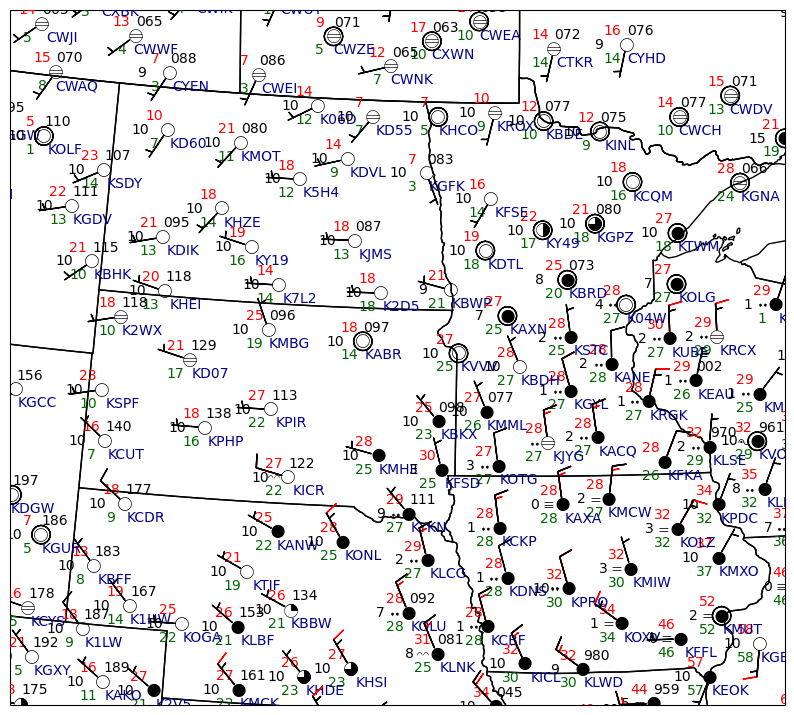

In [10]:
#create wind gust vectors
#get wind direction from metpy
u = data_thinned.eastward_wind.values * units('knots')
v = data_thinned.northward_wind.values * units('knots')
gust = data_thinned.wind_gust.values * units('knots')
#print(u)
wdir = mpcalc.wind_direction(u,v)
#get wind gust components assuming same direction using metpy wind components
ug,vg = mpcalc.wind_components(gust,wdir)

#map projection
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the Northern Plains
ax.set_extent((-105, -90, 40, 50))


#create stationplot (will actually need to create 2 to handle wind gusts)
stationplots = StationPlot(ax,data_thinned['longitude'],data_thinned['latitude'],transform=ccrs.PlateCarree(),clip_on=True,fontsize=10)
stationplots_gusts = StationPlot(ax,data_thinned['longitude'],data_thinned['latitude'],transform=ccrs.PlateCarree(),clip_on=True,fontsize=10)


#temperature in red
stationplots.plot_parameter((-1,1), data_thinned['air_temperature'].values, color='red')
#dewpoint in dark green
stationplots.plot_parameter((-1,-1), data_thinned['dew_point_temperature'].values, color='darkgreen')

#pressure (need to format to be the final 3 digits)
stationplots.plot_parameter((1,1), data_thinned['air_pressure_at_sea_level'].values, color='black',
                               formatter=lambda p: format(10*p, '.0f')[-3:])

#station ID in dark blue
stationplots.plot_text((1.5,-1), data_thinned['station_id'].values, color='darkblue')

#visibility in black (need to convert from meters to miles)
stationplots.plot_parameter((-2,0),data_thinned['visibility'].values*units('meters').to(units('miles')),color='black')

#wind gust in red
stationplots_gusts.plot_barb(ug,vg,color='red',zorder=9)

#wind in black
stationplots.plot_barb(u,v,color='black',zorder=10)

#cloud cover
stationplots.plot_symbol((0,0), data_thinned['cloud_coverage'].values, sky_cover)

#current weather
stationplots.plot_symbol((-1,0), data_thinned['current_wx1_symbol'].values, current_weather)

#save the map as surface_obs.png